In [39]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import glob

In [44]:
# Load data
def load_data(data_path):
    if os.path.isfile(data_path):
        data = np.genfromtxt(data_path, names=True, delimiter=",")
        return data
    else:
        return None
    
def load_csv_files(directory, data_type):
    csv_files = glob.glob(os.path.join(directory, '*' + data_type + '.csv'))

    data_dict = {}

    for csv_file in csv_files:
        data = load_data(csv_file)
        label = os.path.splitext(os.path.basename(csv_file))[0]
        label = label[:label.rfind(data_type)-1]
        data_dict[label] = data

    if len(data_dict) == 0:
        print("Failed to load any data!")

    return data_dict

def filter_nan(data_dict):
    for label, data in data_dict.items():
        data_clean = data[~np.isnan(data["stability"])]
        count_cleaned = len(data["stability"]) - len(data_clean["stability"])
        if count_cleaned > 0:
            print(f"{label}: Removed {count_cleaned} entries with nan stability")
            data_dict[label] = data_clean
    
folder = "../../data"
data_dict_imu = load_csv_files(folder, "imu")
data_dict_stability = load_csv_files(folder, "stability")
filter_nan(data_dict_stability)
print(f"Loaded {len(data_dict_imu)} imu datasets.")
for label, data_imu in data_dict_imu.items():
    print(label)
print(f"Loaded {len(data_dict_stability)} stability datasets.")
for label, data_imu in data_dict_stability.items():
    print(label)

whole_body_assistance_trial-0: Removed 11 entries with nan stability
teleop_trial-0: Removed 1 entries with nan stability
Loaded 2 imu datasets.
teleop_trial-0
whole_body_assistance_trial-0
Loaded 2 stability datasets.
whole_body_assistance_trial-0
teleop_trial-0


In [83]:
def compute_stability_bins(travelled_distance, stability, bin_size):
    # Define bin edges
    min_distance = travelled_distance.min()
    max_distance = travelled_distance.max()
    bins = np.arange(min_distance, max_distance + bin_size, bin_size)
    # print(bins)

    # Assign each travelled_distance value to a bin
    bin_indices = np.digitize(travelled_distance, bins)

    # Calculate the average stability for each bin
    binned_stability = np.zeros(len(bins) - 1)
    for i in range(1, len(bins)):
        indices = np.where(bin_indices == i)[0]
        if indices.size > 0:
            binned_stability[i-1] = np.mean(stability[indices])
        else:
            print(f"[WARNING] Bin ({bins[i-1]},{bins[i]}) is empty")

    bin_values = bins[0:len(bins)-1] + bin_size / 2.0

    # The binned_stability dictionary now contains the average stability values for each bin
    # print(bin_values)
    # print(binned_stability)
    # for bin_range, avg_stability in binned_stability.items():
    #     print(f"Bin {bin_range}: Average Stability = {avg_stability}")

    return bin_values, binned_stability



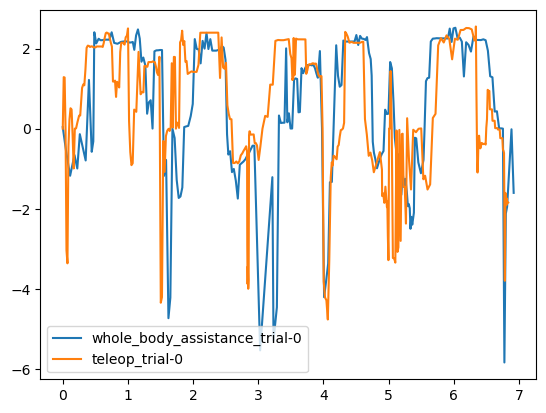

In [89]:
# Stability plot
# Raw relative probability per sample
fig, ax = plt.subplots()
for label, data in data_dict_stability.items():

    # bin_size = 0.15
    # bin_values, binned_stability = compute_stability_bins(data["travelled_distance"], data["stability"], bin_size)
    # ax.bar(bin_values, binned_stability, width=bin_size)

    ax.plot(data["travelled_distance"], data["stability"], label=label)
ax.legend()
plt.show()

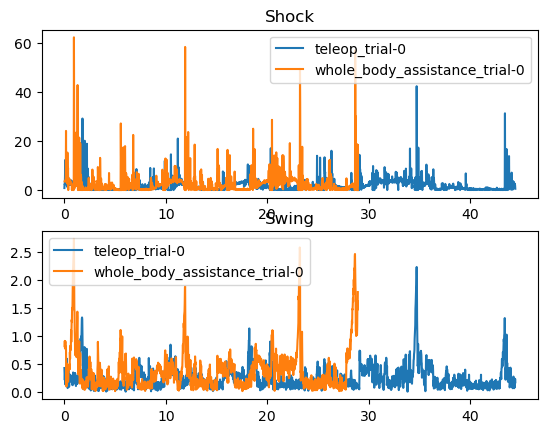

In [117]:
fig, axs = plt.subplots(2, 1)
axs[0].title.set_text("Shock")
axs[1].title.set_text("Swing")
for label, data in data_dict_imu.items():
    gravity = 9.81
    shock_sum = np.abs(data["linear_acceleration_x"]) + np.abs(data["linear_acceleration_y"]) + np.abs(data["linear_acceleration_z"]) - gravity
    shock = np.maximum(shock_sum, 0.0)
    axs[0].plot(data["time"], shock, label=label)

    swing = np.abs(data["angular_velocity_x"]) + np.abs(data["angular_velocity_y"]) + np.abs(data["angular_velocity_z"])
    swing = np.maximum(swing, 0.0)
    axs[1].plot(data["time"], swing, label=label)
axs[0].legend()
axs[1].legend()


In [120]:
# Compute trial metrics
def compute_metrics(data_imu, data_stability):
    # time
    duration = max(data_imu["time"][-1], data_stability["time"][-1])
    print(f" -- Duration: {duration:.2f}s")

    # Average stability
    avg_stability = np.mean(data_stability["stability"])
    print(f" -- Avg. stability: {avg_stability:.2f}")
    _, binned_stability = compute_stability_bins(data_stability["travelled_distance"], data_stability["stability"], 0.12)
    avg_binned_stability = np.mean(binned_stability)
    print(f" -- Avg. binned stability: {avg_binned_stability:.2f}")


    # Locomotion roughness
    shock = np.abs(data_imu["linear_acceleration_x"]) + np.abs(data_imu["linear_acceleration_y"]) + np.abs(data_imu["linear_acceleration_z"]) - gravity
    shock = np.maximum(shock, 0.0)
    avg_shock = np.mean(shock)
    accumulated_shock = np.sum(shock)
    print(f" -- Avg. shock: {avg_shock:.2f}, Acc. shock: {accumulated_shock:.2f}")


    swing = np.abs(data_imu["angular_velocity_x"]) + np.abs(data_imu["angular_velocity_y"]) + np.abs(data_imu["angular_velocity_z"])
    swing = np.maximum(swing, 0.0)
    avg_swing = np.mean(swing)
    accumulated_swing = np.sum(swing)
    print(f" -- Avg. swing: {avg_swing:.2f}, Acc. swing: {accumulated_swing:.2f}")

for label, data_imu in data_dict_imu.items():
    print(f"Trial {label} metrics:")
    data_stability = data_dict_stability[label]
    compute_metrics(data_imu, data_stability) 

Trial teleop_trial-0 metrics:
 -- Duration: 44.44s
 -- Avg. stability: 0.43
 -- Avg. binned stability: 0.67
 -- Avg. shock: 1.76, Acc. shock: 3909.55
 -- Avg. swing: 0.25, Acc. swing: 556.06
Trial whole_body_assistance_trial-0 metrics:
 -- Duration: 28.92s
 -- Avg. stability: 0.57
 -- Avg. binned stability: 0.48
 -- Avg. shock: 2.74, Acc. shock: 3955.01
 -- Avg. swing: 0.38, Acc. swing: 553.74


In [ ]:
#